# Hydropower

This notebook models hydropower generation based on rainfall-to-inflow conversion and reservoir characteristics.

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from ecmwf.opendata import Client

## 1. Power Plant Configuration

Find a list of power plants at https://openinframap.org/stats/area/Kenya/plants. 

* Gitaru Hydro Power Station is a hydro power plant operated by KenGen with a total output of 225 MW.

In [21]:
location_name = "Gitaru Hydro Power Station"
lat_point=-0.784832
lon_point=37.746030
output_mw = 225

## 2. Load forecast data

In [ ]:
var_dict = {
    '2t': 't2m',   # 2m temperature
    'tp': 'tp',     # Total precipitation
}

area_bbox = [18, 32, -5, 52]  

# Parameters to download
parameters = ['2t', 'tp']  

# Forecast steps (in hours, 6-hourly intervals up to 360 hours = 15 days)
steps = list(range(0, 361, 6))

# Output directory
oper_out_dir = Path("data/AIFS/output")
oper_out_dir.mkdir(parents=True, exist_ok=True)

client = Client(
    "ecmwf", 
    model="aifs-single",  # ECMWF's AI-based Integrated Forecast System
    resol="0p25",         # 0.25 degree resolution (~28 km)
)


for param in parameters:

    print(f"Downloading parameter: {param} ({var_dict.get(param, param)})")
    
    filename = 'tmp_oper.nc'
    
    # Retrieve operational forecast from latest run
    print("Retrieving data from ECMWF...")
    client.retrieve(
        date=0,           # Latest available date (0 = today)
        time=0,           # 00z run (can also use 6, 12, or 18 for other runs)
        step=steps,       # Forecast steps: 0, 6, 12, ..., 360 hours
        stream="oper",    # Operational high-resolution forecast
        type="fc",        # Forecast type
        levtype="sfc",    # Surface level
        param=param,      # Parameter to download
        target=filename   # Temporary file
    )
    print(f"Data downloaded to {filename}")

    print("Loading dataset...")
    ds = xr.open_dataset(filename, engine="cfgrib")

    # Convert step to timedelta and extract region
    ds['step'] = pd.to_timedelta(ds.step.values)
    ds = ds.sel(
        latitude=slice(area_bbox[0], area_bbox[2]), 
        longitude=slice(area_bbox[1], area_bbox[3])
    )

    # Get forecast initialization time
    forecast_datetime = ds.time.values
    forecast_datetime_str = pd.to_datetime(forecast_datetime).strftime("%Y%m%d%H%M%S")

    print(f"Forecast run time: {pd.to_datetime(forecast_datetime)}")
    print(f"Dataset shape: {ds[var_dict[param]].shape}")
    print(f"Time steps: {len(ds.step.values)}")

    # Save the extracted dataset
    out_fname = oper_out_dir / f'{forecast_datetime_str}-{steps[-1]}h_{param}.nc'
    ds.to_netcdf(out_fname)
    print(f"Saved to: {out_fname}")

    # Clean up temporary file
    Path(filename).unlink(missing_ok=True)

Retrieving data from ECMWF...


<multiple>:   0%|          | 0.00/30.4M [00:00<?, ?B/s]

Ignoring index file 'tmp_oper.nc.5b7b6.idx' older than GRIB file


By downloading data from the ECMWF open data dataset, you agree to the terms: Attribution 4.0 International (CC BY 4.0). Please attribute ECMWF when downloading this data.
Data downloaded to tmp_oper.nc
Loading dataset...
Forecast run time: 2025-11-06 00:00:00
Dataset shape: (61, 93, 81)
Time steps: 61
Forecast run time: 2025-11-06 00:00:00
Dataset shape: (61, 93, 81)
Time steps: 61
Saved to: data\AIFS\output\20251106000000-360h_2t.nc
Retrieving data from ECMWF...
Saved to: data\AIFS\output\20251106000000-360h_2t.nc
Retrieving data from ECMWF...


<multiple>:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Ignoring index file 'tmp_oper.nc.5b7b6.idx' older than GRIB file


Data downloaded to tmp_oper.nc
Loading dataset...
Forecast run time: 2025-11-06 00:00:00
Dataset shape: (61, 93, 81)
Time steps: 61
Saved to: data\AIFS\output\20251106000000-360h_tp.nc
Saved to: data\AIFS\output\20251106000000-360h_tp.nc


In [8]:
ds_2t= xr.open_dataset("data/AIFS/output/20251106000000-360h_2t.nc")
ds_tp= xr.open_dataset("data/AIFS/output/20251106000000-360h_tp.nc")

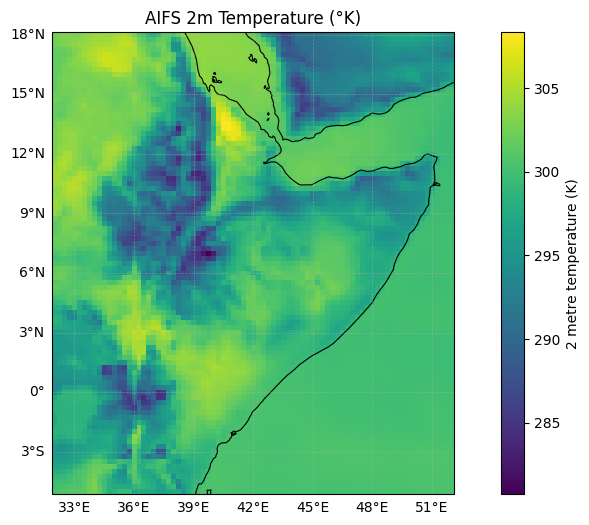

(<Figure size 1200x600 with 2 Axes>,
 <GeoAxes: title={'center': 'AIFS 2m Temperature (°K)'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

In [12]:
# plot temperature at 2m height

from plot import plot_variable
plot_variable(
    ds_2t.sel(step="18:00:00"),
    var_name='t2m',
    title='AIFS 2m Temperature (°K)',
)


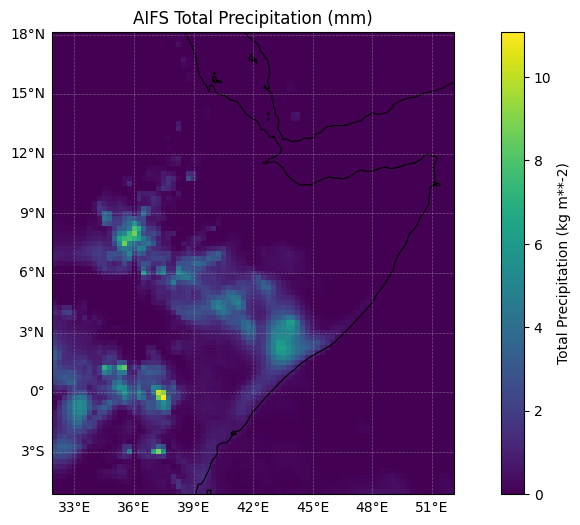

(<Figure size 1200x600 with 2 Axes>,
 <GeoAxes: title={'center': 'AIFS Total Precipitation (mm)'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

In [14]:
plot_variable(
    ds_tp.sel(step="18:00:00"),
    var_name='tp',
    title='AIFS Total Precipitation (mm)',
)


In [17]:
forecast_location_tp = ds_tp['tp'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

forecast_location_t2m = ds_2t['t2m'].sel(
    latitude=lat_point,
    longitude=lon_point,
    method='nearest'
)

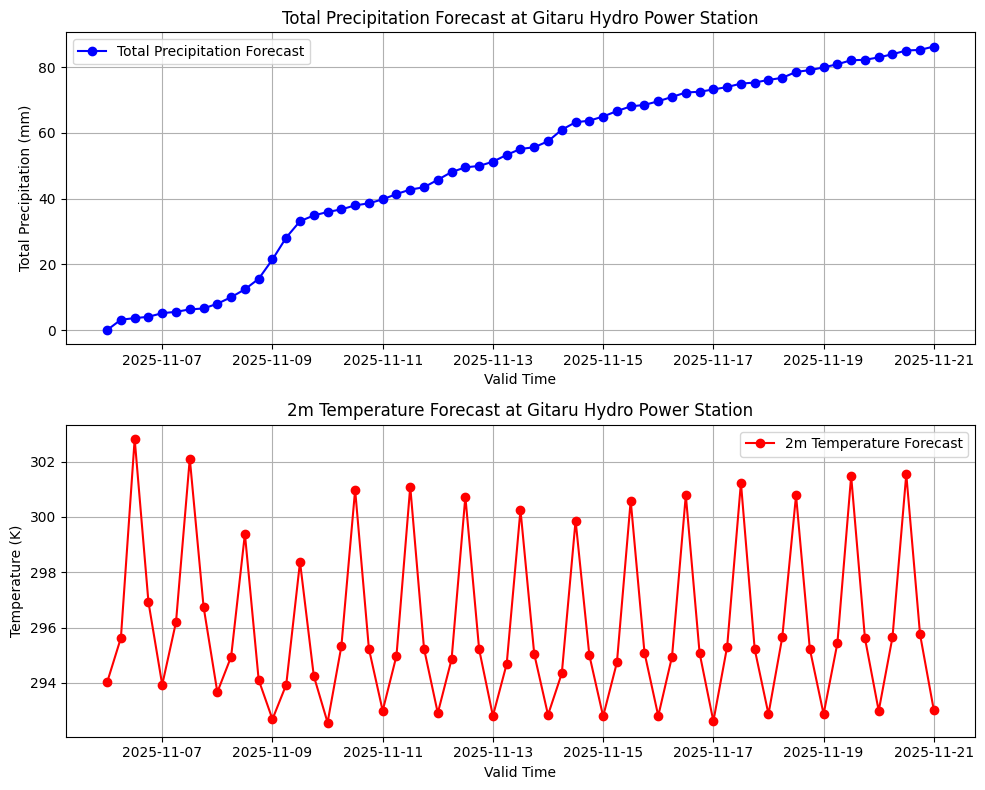

In [18]:
plt.figure(figsize=(10, 8))

# Subplot 1: Total Precipitation
plt.subplot(2, 1, 1)
plt.plot(forecast_location_tp.valid_time, forecast_location_tp, marker='o', label='Total Precipitation Forecast', color='blue')
plt.title(f'Total Precipitation Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Total Precipitation (mm)')
plt.grid()
plt.legend()

# Subplot 2: 2m Temperature
plt.subplot(2, 1, 2)
plt.plot(forecast_location_t2m.valid_time, forecast_location_t2m, marker='o', label='2m Temperature Forecast', color='red')
plt.title(f'2m Temperature Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Temperature (K)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
valid_times = forecast_location_tp.valid_time[1:]

forecast_sum_daily_tp = forecast_location_tp.groupby("valid_time.day").sum(dim="step")
forecast_sum_daily_t2m = forecast_location_t2m.groupby("valid_time.day").mean(dim="step")

# skip last day if incomplete
forecast_sum_daily_tp = forecast_sum_daily_tp[:-1]
forecast_sum_daily_t2m = forecast_sum_daily_t2m[:-1]

valid_times_days = pd.date_range(
    start=pd.to_datetime(valid_times.values[0]).replace(hour=0, minute=0, second=0),
    end=pd.to_datetime(valid_times.values[-1]).replace(hour=0, minute=0, second=0),
    freq='D'
)[:-1]

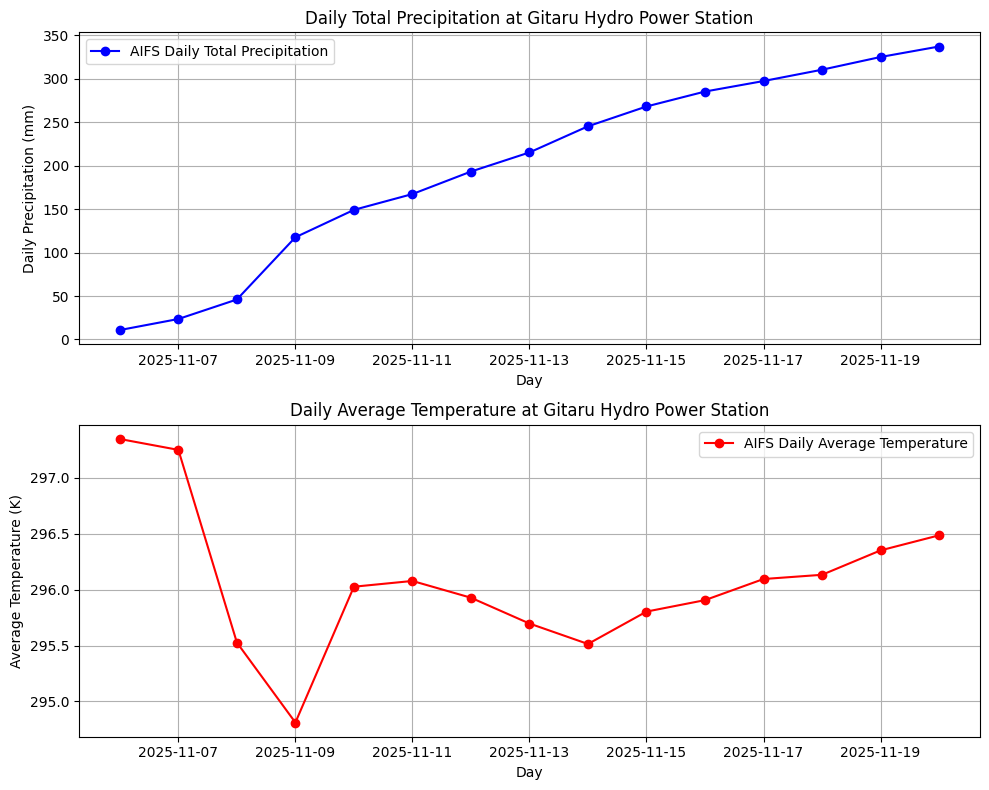

In [25]:
plt.figure(figsize=(10, 8))

# Subplot 1: Daily Total Precipitation
plt.subplot(2, 1, 1)
plt.plot(valid_times_days, forecast_sum_daily_tp, marker='o', label='AIFS Daily Total Precipitation', color='blue')
plt.title(f'Daily Total Precipitation at {location_name}')
plt.xlabel('Day')
plt.ylabel('Daily Precipitation (mm)')
plt.grid()
plt.legend()

# Subplot 2: Daily Average Temperature
plt.subplot(2, 1, 2)
plt.plot(valid_times_days, forecast_sum_daily_t2m, marker='o', label='AIFS Daily Average Temperature', color='red')
plt.title(f'Daily Average Temperature at {location_name}')
plt.xlabel('Day')
plt.ylabel('Average Temperature (K)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## 3. Hydropower Model

In [26]:
# Hydropower plant parameters

head = 50.0     # head [m] (example)
eta = 0.9       # turbine efficiency
k1 = 0.1
k2 = 0.02

In [ ]:
def rainfall_inflow(
        P_rain, 
        P_rain_t_min_1, 
        k1, 
        k2
    ):
    """
    Convert rainfall to reservoir inflow using linear reservoir model.
    Parameters:
    P_rain : current precipitation [mm/day]
    P_rain_t_min_1 : previous time step precipitation [mm/day]
    k1, k2 : coefficients mapping rainfall to inflow
    """
    Q_inflow = k1 * P_rain + k2 * P_rain_t_min_1
    return Q_inflow

def hydropower(
        Q_inflow,
        head, 
        eta, 
        output_mw, 
        rho=1000
    ):
    """Calculate hydropower output from flow rate and head.
    
    Parameters:
    Q_inflow : flow rate [m³/s]
    head : hydraulic head [m]
    eta : turbine efficiency [dimensionless]
    output_mw : installed capacity [MW]
    rho : water density [kg/m³]
    """
    P_hydro = eta * rho * 9.81 * head * Q_inflow / 1e6  # Convert to MW
    P_hydro = xr.where(P_hydro > output_mw, output_mw, P_hydro)  # Cap at installed capacity
    return P_hydro


In [36]:
inflow = rainfall_inflow(
    forecast_sum_daily_tp.values,
    forecast_sum_daily_tp.shift(day=1).values,
    k1,
    k2
)

power_forecast = hydropower(
    inflow,
    head,
    eta,
    output_mw
)


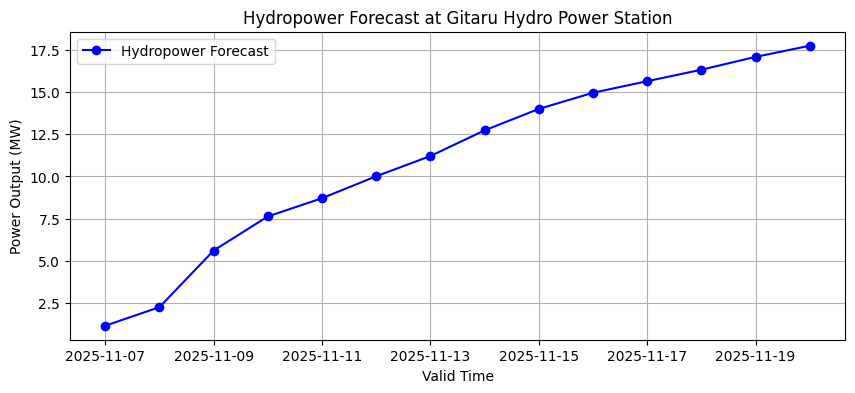

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(valid_times_days, power_forecast, marker='o', label='Hydropower Forecast', color='blue')
plt.title(f'Hydropower Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Power Output (MW)')
plt.grid()
plt.legend()
plt.show()